# Grad-CAM

*Louis Martinez*

[Research Paper](https://arxiv.org/pdf/1610.02391)  
[Article about Guided backpropagation](https://arxiv.org/pdf/1412.6806)  
[Addional explanations](https://medium.com/@chinesh4/generalized-way-of-interpreting-cnns-a7d1b0178709)  
[PyTorch documentation about hooks](https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html)

Among all the various visual ways to explain how a CNN behaves Class Activation Mapping (CAM) allows to visualize where is a CNN "looking" when searching for some elements of interests, in a classification task for instance. However, the authors of the articles use the same pipeline for other tasks such as image captioning and Visual Question Answering (VQA), which can turn out to be convenient in the framework of multimodal AI.

What's more, the paper introduces Guided Grad-CAM which is a way to generate *high-resolution class-discriminative visualization*. This method is based on Guided Back Propagation, which is further developed below.

Compared to previous approaches to generate such maps, we don't have to radically change the structure of the CNN we want to visualize, as it is gradient-based (further explanations in the article).

This notebook is divided into two main parts:
1. It first focuses on a step-by-step implementation of the method proposed by the article and on a comprehensive explanation of the intuition behind it. All the major formulas in the article are explained too.
2. All the previous explanations are grouped together in a set of generic, easy-to-use functions, which are then used to carry out other experiments based on those developed in the article.

## Setup and imports

As the base models used in this notebook are all pre-trained on Imagenet dataset, we use the Imagenette dataset, which is a 10 classes subset of Imagenet.

In [1]:
! wget -q https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
! wget -q https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
! tar xf imagenette2-320.tgz

### Imports

In [2]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
from skimage.transform import resize

mpl.rcParams['figure.figsize'] = (6,6)

root_imgs = os.path.join('imagenette2-320', 'train')
root_classes = os.listdir(root_imgs)
with open('imagenet_class_index.json') as f:
    imagenet_classes = json.load(f)
name_to_id_classes = {name: id for id,name in imagenet_classes.values()}

def torch2np(img):
    if img.ndim == 4:
        img = img.squeeze(0)
    return img.detach().numpy().transpose(1,2,0)

def rescale(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def normalize(arr):
    arr = torch.tensor(arr.transpose(2,0,1))
    arr = T.Normalize(mean=(.5,.5,.5), std=(.05,.05,.05))(arr)
    return np.clip(arr.numpy().transpose(1,2,0), 0., 1.)

def overlay_cam(im, cam, alpha=0.4, clipping=0.15):
    im = np.asarray(im) / 255
    cam = plt.cm.jet(cam)[..., :3]
    cam = np.clip(cam, clipping, None)
    overlay = alpha * cam + (1 - alpha) * im
    return overlay

def show_result(im, title=None):
    plt.figure()
    plt.imshow(im)
    plt.axis('off')
    if title is not None: plt.title(title)
    plt.show()

## Defining the method

We know that the outputs of firsts convolutional layers of a CNN mainly capture content information, where the last layers capture the semantic information. What's more, every concolutional layer keep track of the spatial information.  So the main assumption of the article is that the last convolutional layer of a CNN is a good tradeoff between spatial and semantic information. In other words, given a class of interest, neurons of the last layer are trained to look for that specific class in the image.
To quantify how nuch a neuron (or here an activation map, hence a set of neurons) contribute to discriminate a class of interest, we focus on the gradient of the output score for this class with respect to the activation map.

Formally speaking, we denote by:
- $c$ the class of interest
- $n$ the number of feature maps after the las convolutional layer
- $y^c$ the raw output of the classifier for class $c$ (raw because we don't use any activation functions sucha as softmax. Hence $y_c$ can hold any real value)
- $A^k$ the k-th feature map of the last convolutional layer ($k\in[1,n]$)

We define $\alpha_k^c$ the neuron importance weight of feature map $A^k$ given $c$. Intuively, it quantifies how important $A^k$ semantically wise, to determine the spatial location of the class of interest $c$.

$$\alpha_k^c=\frac{1}{Z}\sum_i\sum_j\frac{\partial y^c}{\partial A_{ij}^k}$$
where $Z$ is a normalization factor (i.e the number of neurons in $A^k$) and $ A_{ij}^k$ is the value of $A^k$ at postition $(i,j)$.

Finally the Class Activation Map $L^c$ is just the weighted sum of all the $A^k$:

$$L^c=ReLU\left(\sum_k \alpha_k^c A^k\right)$$

**Important notes**

- **Why a ReLU?**  
The goal of these Class Activation Maps is the hightlight the neurons that positively contribute in finding the location of the class of interest. Intuitively, negative values illustrate the fact that these pixels belong to other classes, or at least not to $c$.

- **Dimension of the activation map**  
As the CAM $L^c$ is a linear combination of activation maps, is has the same shape as these latter. Hence $L^c$ is then upscaled with bilinear interpolation (according to the article) to match the shape of the input image.

### Implementation details

Here we apply the process on the VGG16 architecture (as in the research paper) pretrained on the Imagenet dataset. The default model has to be modified such that we can hook and store the gradient maps of the last convolutional (the deepest) layer during the backward propagation with respect to the class of interest.

Besides the usual functions we can find within a PyTorch module, there are a couple more essential to adapt the default VGG16 default model.

**Keeping track of gradients**  
As mentioned above, we need to compute the gradient of the class of interest with respect to the activation maps outputed by the last convolutional layer.

**Setting up guided-backpropagation**  
As well as explaining how to generate CAMs, the article explains how to combine them with guided-backpropagation. As mentioned before, $L^c$ must be resized to the shape of the image, leading to a coarse result. Indeed, $L^c$ as a shape around $(10\times 10)$ pixels (order of magnitude) where the input image shape is around $(100\times 100)$ pixels. Hence the article introduces Guided Grad-CAM as a way to generate a high resolution class discriminative map. To do so, we multiply both maps element-wise ($L^c$ upscaled and guided-backpropagation).  
Guided back-propagation combines legacy backpropagation and DeconNets. It aims to set all the negative gradients to 0, as we're only interested in the pixels positively contributing to features detection in images. Deeper explanations are provided in the article mentioned above.  
*Practically speaking, we just have to set all the negative gradient values to zero*

In [94]:
class GradCAM(nn.Module):
    """
    Wrapper used to compute all the required features for the generation of CAM and Guided Grad-CAM
    It is built on the VGG16 architecture as in the original article, although it could be replaced by any other VGG network
    """

    def __init__(self):
        super().__init__()
        base_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1, progress=False)
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = base_model.classifier

        self.transform = T.Compose([
            T.Resize([256, 256], interpolation=T.InterpolationMode.BILINEAR),
            T.CenterCrop([224,224]),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Variable to store gradients of the last conv layer
        self.last_conv_grads = None

        # Replace inplace ReLU by the default ones, to be able to hook the new relu gradient
        self.replace_inplace_modules(self.features)
        self.replace_inplace_modules(self.classifier)

        # Replaces the gradient computation for all ReLU layers
        self.register_relu_hook()

    def replace_inplace_modules(self, net):
        for i, module in enumerate(net):
            if isinstance(module, nn.ReLU):
                net[i] = nn.ReLU(inplace=False)

    def register_relu_hook(self):
        for module in self.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(self.guided_relu)

    def guided_relu(self, module, grad_input, grad_output):
        return (torch.clamp(grad_input[0], min=0.),)

    def store_grads(self, grad):
        self.last_conv_grads = grad

    def prepare_input(self, img):
        input = self.transform(img).unsqueeze(0)
        input.requires_grad = True
        return input

    def forward(self, x):
        activations = self.features(x)
        # Hook the gradient during backward pass (cf torch documentation)
        activations.register_hook(self.store_grads)
        y = self.avgpool(activations)
        y = nn.Flatten()(y)
        y = self.classifier(y)
        return y, activations

    def average_gradients(self):
        """
        Computes the neuron importance weights (alpha in the research paper)

        Returns
        ------
        alphas: torch.tensor
            neuron importance weights
            contains as many coefficients as feature maps in the last convolutional layer
        """
        if self.last_conv_grads is None: raise TypeError('GradCAM.last_conv_grads is None. Make sure you\'ve performed a backward pass')
        alphas = torch.mean(self.last_conv_grads, dim=[2,3]).squeeze(0).view(-1, 1, 1)
        return alphas


    def compute_CAM(self, alphas, activations):
        return nn.ReLU()(torch.sum(alphas * activations, dim=0)).detach().numpy()

model = GradCAM().eval()

### Testing the method

Here we apply the method on English springers images (they're cute).

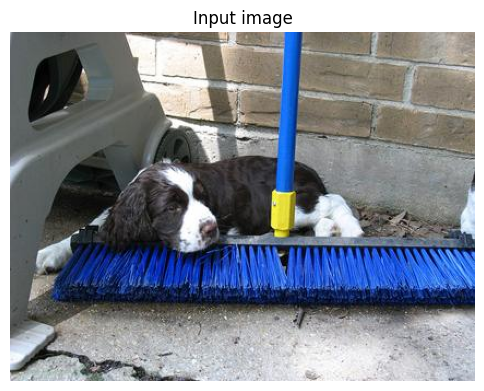

In [105]:
results = {}

springer_id = name_to_id_classes['English_springer']
springer_img = os.listdir(os.path.join(root_imgs, springer_id))[2]

# Load the image
im = Image.open(os.path.join(root_imgs, springer_id, springer_img))

# Apply preprocessing step for imagenet
input = model.prepare_input(im)

title = 'Input image'
results[title] = im
show_result(im, title=title)

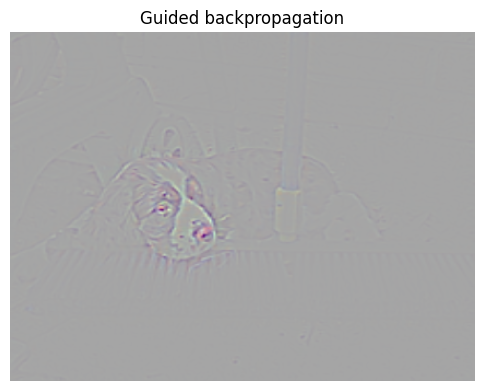

In [96]:
# Run forward propagation
out, activations = model(input)
class_index = out.argmax(dim=1).item()

# Run backpropagation with respect to the class of interest
out[:, class_index].backward()

# Compute guided backpropagation image
guided = torch2np(input.grad)
guided = rescale(guided)
guided = resize(guided, np.flip(im.size), order=1)


title = 'Guided backpropagation'
results[title] = guided
show_result(guided, title=title)

Now that we've backpropagated the gradients through the network, not only do we have the guided-backpropagation map, but we also have access to the gradient of the activations of the last convolutional layer. Hence, we can compute the neuron importance weights $(\alpha_k^c)_{k\in[1,n]}$ and ultimately the Class Activation Map

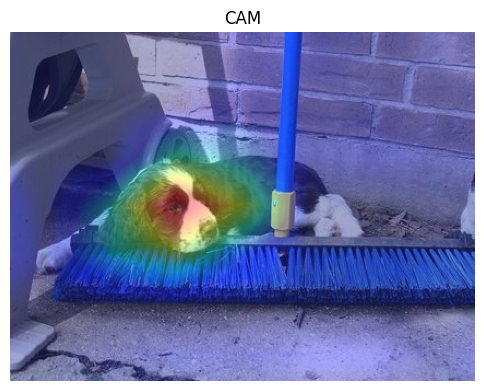

In [97]:
# Compute neuron importance weights
alphas = model.average_gradients()

# Delete the batch dimension of activations tensor
activations = activations.squeeze(0)

# Compute the class activation map
cam = model.compute_CAM(alphas, activations)

# Resize to the shape of the input image
cam = resize(cam, np.flip(im.size), order=1)

# Rescale cam values between 0 and 1
cam = rescale(cam)



# Overlay the cam on the input image
overlay = overlay_cam(im, cam)
title = 'CAM'
results[title] = overlay
show_result(overlay, title=title)

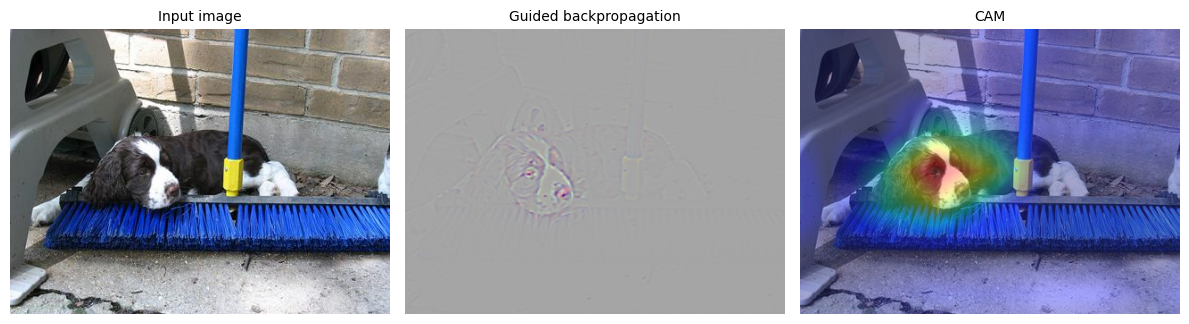

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))
for i, (title, im) in enumerate(results.items()):
    ax[i].imshow(im)
    ax[i].set_title(title, fontsize=10)
    ax[i].axis('off')
plt.tight_layout()

## Wrapping up everything (WORK IN PROGRESS)

Here is a production-ready implementation of Grad-CAM.  
The only requirements to make it work on any CNN is that all the convolutional layer are grouped in a single module called features. The CAM is determined with respect to the last layer of this module.

In [3]:
class CAMGenerator(nn.Module):

    def __init__(self, model, transform=None):
        super().__init__()
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = model.classifier

        self.transform = transform

        # Variable to store gradients of the last conv layer
        self.last_conv_grads = None
        self.im = None
        self.input = None
        self.im_shape = None
        self.cam = None

        # Replace inplace ReLU by the default ones, to be able to hook the new relu gradient
        self.replace_inplace_modules(self.features)
        self.replace_inplace_modules(self.classifier)

        # Replaces the gradient computation for all ReLU layers
        self.register_relu_hook()

    def replace_inplace_modules(self, net):
        for i, module in enumerate(net):
            if isinstance(module, nn.ReLU):
                net[i] = nn.ReLU(inplace=False)

    def register_relu_hook(self):
        for module in self.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(self.guided_relu)

    def guided_relu(self, module, grad_input, grad_output):
        return (torch.clamp(grad_input[0], min=0.),)

    def store_grads(self, grad):
        self.last_conv_grads = grad

    def prepare_input(self, im):
        if self.transform is not None:
            input = self.transform(im)
        input = input.unsqueeze(0)
        input.requires_grad = True
        return input

    def forward(self, x):
        activations = self.features(x)
        # Hook the gradient during backward pass (cf torch documentation)
        activations.register_hook(self.store_grads)
        y = self.avgpool(activations)
        y = nn.Flatten()(y)
        y = self.classifier(y)
        return y, activations

    def average_gradients(self):
        """
        Computes the neuron importance weights (alpha in the research paper)

        Returns
        ------
        alphas: torch.tensor
            neuron importance weights
            contains as many coefficients as feature maps in the last convolutional layer
        """
        if self.last_conv_grads is None: raise TypeError('GradCAM.last_conv_grads is None. Make sure you\'ve performed a backward pass')
        alphas = torch.mean(self.last_conv_grads, dim=[2,3]).view(1, -1, 1, 1)
        return alphas


    def compute_CAM(self, alphas, activations):
        return nn.ReLU()(torch.sum(alphas * activations, dim=1)).detach()

    def rescale(self, arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    def guided_backprop(self):
        guided = self.input.grad.detach().squeeze(0)
        guided = self.rescale(guided)
        guided = T.Resize(self.im_shape)(guided)
        return guided

    def overlay_cam_on_image(self, alpha=0.4, clipping=0.15):
        im = np.asarray(self.im) / 255
        cam = plt.cm.jet(self.cam)[..., :3]
        cam = np.clip(cam, clipping, None)
        overlay = alpha * cam + (1 - alpha) * im
        return overlay

    def run(self, im, class_choice='best_pred'):
        self.im_shape = im.shape if isinstance(im, np.ndarray) else tuple(np.flip(im.size))
        self.im = im
        self.input = self.prepare_input(im)
        out, activations = self.forward(self.input)

        if class_choice == 'best_pred':
            class_index = out.argmax(dim=1).item()
        elif isinstance(class_choice, int):
            class_index = class_choice
            if out.shape[1] <= class_index:
                raise IndexError('class_choice value is greater than the number of output values')
        else:
            raise TypeError('class_choice must be either "best_pred" or a non negative integer')

        # Run backpropagation with respect to the class of interest
        out[:, class_index].backward()

        # Compute neuron importance weights [B, C, W, H]
        alphas = self.average_gradients()

        # Compute the class activation map
        cam = self.compute_CAM(alphas, activations)

        # Resize to the shape of the input image
        cam = T.Resize(self.im_shape)(cam)
        # Rescale cam values between 0 and 1
        cam = self.rescale(cam)

        self.cam = cam.squeeze(0)

        return self.cam

In [4]:
springer_id = name_to_id_classes['English_springer']
springer_im = os.listdir(os.path.join(root_imgs, springer_id))[2]

im = Image.open(os.path.join(root_imgs, springer_id, springer_im))
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1, progress=False)
transform = T.Compose([
            T.Resize([256, 256], interpolation=T.InterpolationMode.BILINEAR),
            T.CenterCrop([224,224]),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])


camgen = CAMGenerator(model, transform)

cam = camgen.run(im, class_choice='best_pred')
overlay = camgen.overlay_cam_on_image()
guided = camgen.guided_backprop()

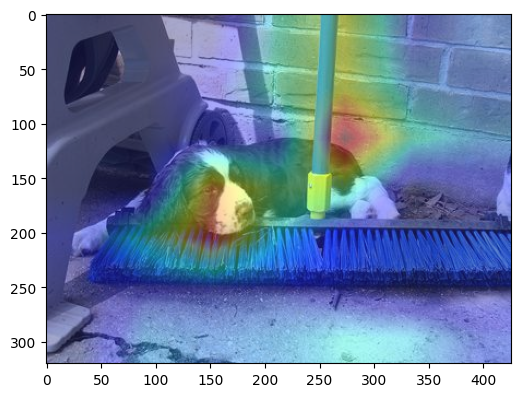

In [5]:
plt.imshow(overlay)